<a href="https://colab.research.google.com/github/svazrala04/Cancer-diagnosis/blob/main/Cancer_Diagnosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

To classify the given genetic variations based on evidence from text-based clinical literature

Data Source :https://www.kaggle.com/competitions/msk-redefining-cancer-treatment/data

Business objective

* Probability of a data point belonging to each class is required.

* No Low latency requirement.




# Exploratory Data Analysis.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore")
import six
import sys
sys.modules['sklearn.externals.six'] = six
from mlxtend.classifier import StackingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression

# Reading Data

##  Reading Gene and variation data

In [ ]:
data = pd.read_csv("/content/training_variants")
print('Number of data points : ', data.shape[0])
print('Number of features : ', data.shape[1])
print('Features : ', data.columns.values)
data.head()

Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading Text Data

In [ ]:
data_text= pd.read_csv("/content/training_text",sep='\|\|', engine="python", names=["ID","TEXT"],skiprows=1)
print("Number of text data rows :" ,data_text.shape[0])
print("Number of text data features: " ,data_text.shape[1])
print("Names of features :", data_text.columns.values)

Number of text data rows : 1317
Number of text data features:  2
Names of features : ['ID' 'TEXT']


In [ ]:
data_text.head(5)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


# Text pre processing

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words= stopwords.words('english')

In [ ]:
def text_preprocessing(total_text, index, column):
  if type(total_text) is not int:
    string =""
    total_text = re.sub('[^a-zA-Z0-9\n]',' ', total_text) #replacing every special char with space
    total_text= re.sub('\s+', ' ', total_text) #replacing multiple spaces with single space
    total_text = total_text.lower() #Converting the text to lowercase
    for word in total_text.split(): # stop word removal
      if not word in stop_words:
        string += word + " "
    data_text[column][index]=string





In [ ]:

for i, row in data_text.iterrows():
  if type(row['TEXT']) is str:
    text_preprocessing(row['TEXT'], i, 'TEXT')
  else:
    print("there is no text description for the id: ", i)
 


there is no text description for the id:  1109
there is no text description for the id:  1277


In [ ]:
# Merging both dataframes of gene variations and text.

final_df = pd.merge(data, data_text, on ='ID', how= 'left')
final_df.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [ ]:
final_df[final_df.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1317,1317,MLH1,W714*,4,NaN
1318,1318,MLH1,R217C,5,NaN
1319,1319,MLH1,I219V,5,NaN
...,...,...,...,...,...
3316,3316,RUNX1,D171N,4,NaN
3317,3317,RUNX1,A122*,1,NaN
3318,3318,RUNX1,Fusions,1,NaN
3319,3319,RUNX1,R80C,4,NaN


In [ ]:
final_df.loc[final_df['TEXT'].isnull(), 'TEXT']= final_df['Gene']+ ' '+ final_df['Variation']

In [ ]:
final_df[final_df['ID']==1109]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,FANCA S1088F


# Train Test CV Split

## Splitting data into train, test and cross validation (64:20:16)

In [ ]:
y_true= final_df['Class'].values
final_df.Gene= final_df.Gene.str.replace('\s+', ' ')
final_df.Variation = final_df.Variation.str.replace('\s+', ' ')
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(final_df, y_true, stratify= y_true, test_size=0.2)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

In [ ]:
print("Number of data points in train data : ",train_df.shape[0])
print("Number of data points in test data :", test_df.shape[0])
print("Number of data points in CV data :", cv_df.shape[0])

Number of data points in train data :  2124
Number of data points in test data : 665
Number of data points in CV data : 532


## Distribution of y_i's in train, test, cv datasets.

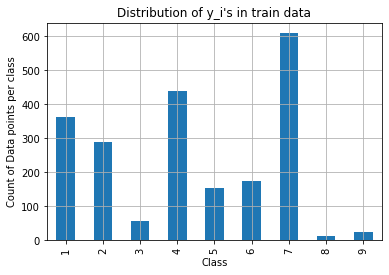

Number of data points of class  7 : 609 ( 28.672 %)
Number of data points of class  4 : 439 ( 20.669 %)
Number of data points of class  1 : 363 ( 17.09 %)
Number of data points of class  2 : 289 ( 13.606 %)
Number of data points of class  6 : 176 ( 8.286 %)
Number of data points of class  5 : 155 ( 7.298 %)
Number of data points of class  3 : 57 ( 2.684 %)
Number of data points of class  9 : 24 ( 1.13 %)
Number of data points of class  8 : 12 ( 0.565 %)
--------------------------------------------------------------------------------


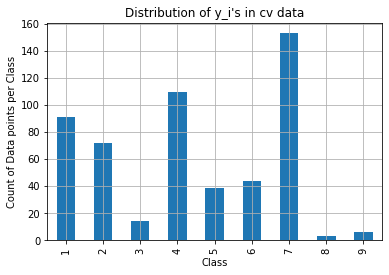

Number of data points in class 7 : 153 ( 28.759 %)
Number of data points in class 4 : 110 ( 20.677 %)
Number of data points in class 1 : 91 ( 17.105 %)
Number of data points in class 2 : 72 ( 13.534 %)
Number of data points in class 6 : 44 ( 8.271 %)
Number of data points in class 5 : 39 ( 7.331 %)
Number of data points in class 3 : 14 ( 2.632 %)
Number of data points in class 9 : 6 ( 1.128 %)
Number of data points in class 8 : 3 ( 0.564 %)
--------------------------------------------------------------------------------


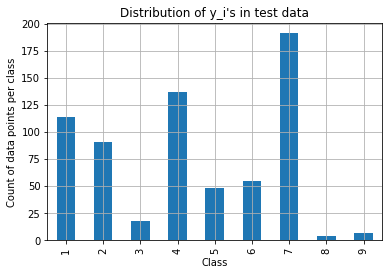

Number of data points of class 7 : 191 ( 28.722 %)
Number of data points of class 4 : 137 ( 20.602 %)
Number of data points of class 1 : 114 ( 17.143 %)
Number of data points of class 2 : 91 ( 13.684 %)
Number of data points of class 6 : 55 ( 8.271 %)
Number of data points of class 5 : 48 ( 7.218 %)
Number of data points of class 3 : 18 ( 2.707 %)
Number of data points of class 9 : 7 ( 1.053 %)
Number of data points of class 8 : 4 ( 0.602 %)


In [ ]:
# Returns class labels and its occurences as dict key and values.
train_class_distribution= train_df['Class'].value_counts().sort_index()
cv_class_distribution=cv_df['Class'].value_counts().sort_index()
test_class_distribution=test_df['Class'].value_counts().sort_index()


my_colors= 'rgbkymc'
train_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count of Data points per class')
plt.title("Distribution of y_i's in train data")
plt.grid()
plt.show()

sorted_yi=np.argsort(-train_class_distribution.values)
for i in sorted_yi:
  print("Number of data points of class ", i+1, ":", train_class_distribution.values[i],'(', np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), '%)')
print('-'*80)
my_colors='rgbkymc'
cv_class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Count of Data points per Class')
plt.title("Distribution of y_i's in cv data")
plt.grid()
plt.show()

sorted_yi=np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
  print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), '%)')

print('-'*80)

my_colors='rgbkymc'
test_class_distribution.plot(kind='bar')
plt.xlabel("Class")
plt.ylabel("Count of data points per class")
plt.title("Distribution of y_i's in test data")
plt.grid()
plt.show()

sorted_yi=np.argsort(-test_class_distribution.values)
for i in sorted_yi:
  print("Number of data points of class", i+1,":", test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i]/test_df.shape[0]*100),3),'%)')


# Prediction using Random Model

In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

In [ ]:
# Defining a function for Confusion Matrix.
def plot_confusion_matrix(test_y,predict_y):
  C= confusion_matrix(test_y, predict_y) 
  
  A=(((C.T)/(C.sum(axis=1))).T)

  B=(C/C.sum(axis=0))

  labels=[1,2,3,4,5,6,7,8,9]

  print("_"*20,"Confusion Matrix", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
  print("-"*20, "Precision matrix (Columm Sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()
    
    # representing B in heatmap format
  print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
  plt.figure(figsize=(20,7))
  sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted Class')
  plt.ylabel('Original Class')
  plt.show()


Log loss on Cross Validation Data using Random Model 2.430925512260429
Log loss on Test data using Random Model 2.477648459166987
____________________ Confusion Matrix --------------------


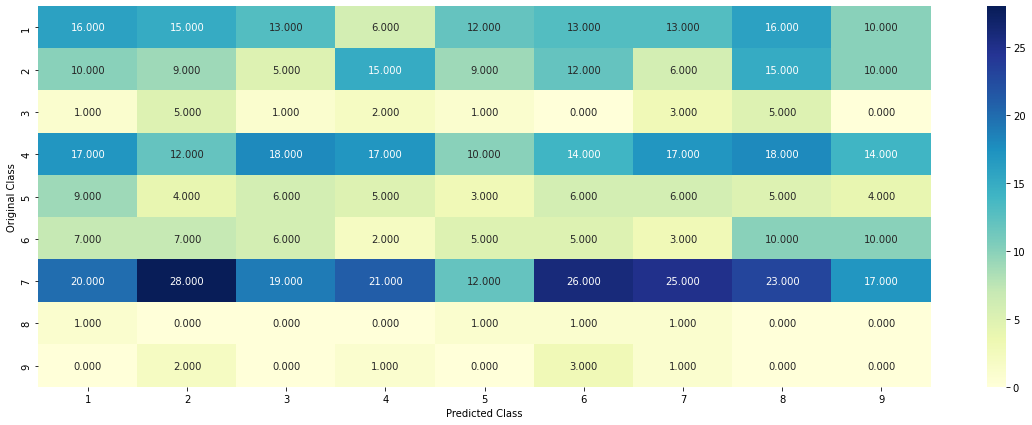

-------------------- Precision matrix (Columm Sum=1) --------------------


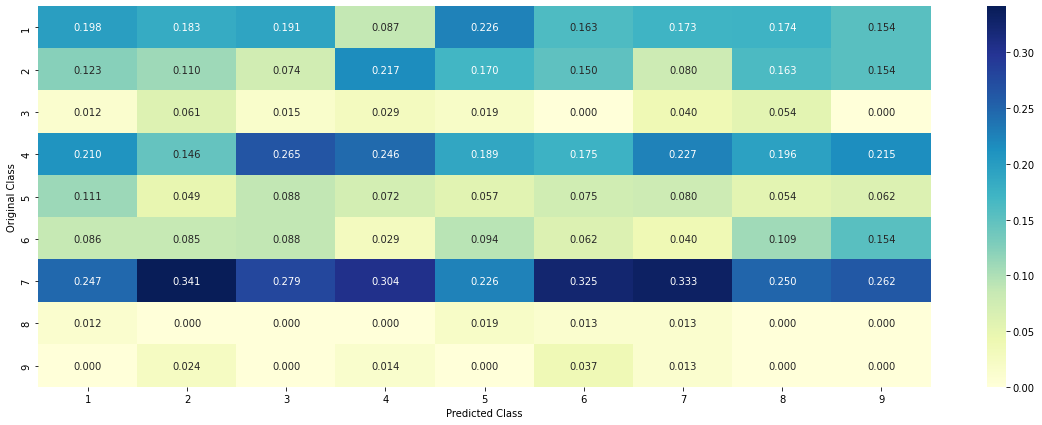

-------------------- Recall matrix (Row sum=1) --------------------


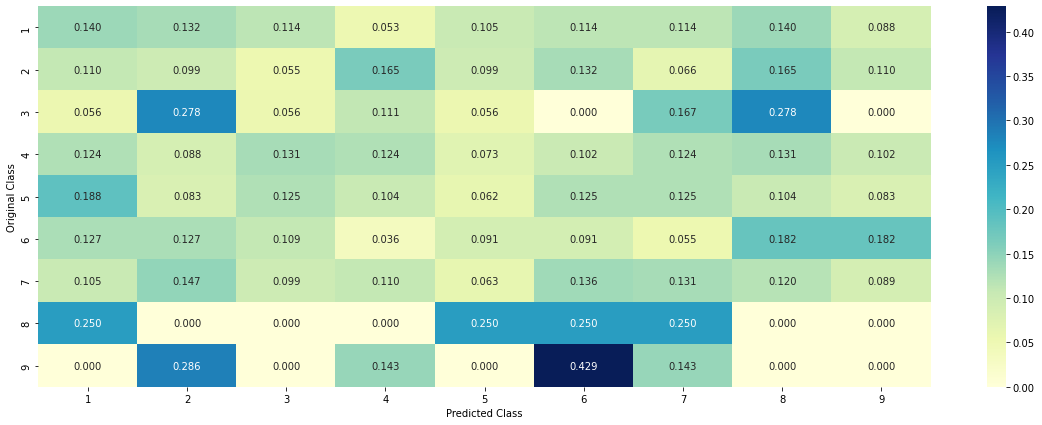

In [ ]:
#  The random function should generate 9 numbers and the sum of numbers should be 1
#one solution is to genarate 9 numbers and divide each of the numbers by their sum
test_data_len= test_df.shape[0]
cv_data_len=cv_df.shape[0]
cv_predicted_y=np.zeros((cv_data_len,9))
for i in range(cv_data_len):
  rand_probs=np.random.rand(1,9)
  cv_predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model", log_loss(y_cv, cv_predicted_y, eps=1e-15))


# Test set error
#we create a output array that has exactly same as the test data
test_predicted_y=np.zeros((test_data_len,9))
for i in range(test_data_len):
  rand_probs=np.random.rand(1,9)
  test_predicted_y[i]=((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test data using Random Model", log_loss(y_test,test_predicted_y, eps=1e-15))
predicted_y=np.argmax(test_predicted_y,axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

# Univariate Analysis

In [ ]:
def get_gv_fea_dict(alpha, feature, df):
  value_count = train_df[feature].value_counts()
  gv_dict = dict()
  for i, denominator in value_count.items():
    vec = []
    for k in range(1,10):
      cls_cnt = train_df.loc[(train_df['Class']==k) & (train_df[feature]==i)]
      vec.append((cls_cnt.shape[0] + alpha*10)/ (denominator + 90*alpha))
    gv_dict[i]=vec
  return gv_dict

In [ ]:
def get_gv_feature(alpha, feature, df):
  gv_dict = get_gv_fea_dict(alpha, feature, df)
  value_count = train_df[feature].value_counts()
  gv_fea = []
  for index, row in df.iterrows():
    if row[feature] in dict(value_count).keys():
      gv_fea.append(gv_dict[row[feature]])
    else:
      gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
  return gv_fea

## Univariate analysis on Gene Feature

Categories of Genes and their distribution.

In [ ]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
print(unique_genes.head(10))

Number of Unique Genes : 234
BRCA1     178
TP53      119
EGFR      101
PTEN       78
BRCA2      74
KIT        62
BRAF       57
ERBB2      47
PIK3CA     40
PDGFRA     40
Name: Gene, dtype: int64


In [ ]:
print(unique_genes.shape[0],"different categories of genes are present in data and their distribution as follows")


234 different categories of genes are present in data and their distribution as follows


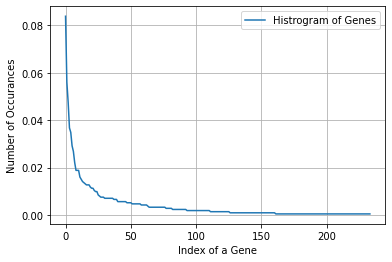

In [ ]:
s = sum(unique_genes.values);
h = unique_genes.values/s;
plt.plot(h, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

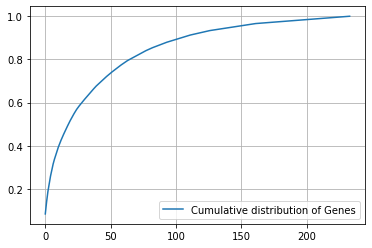

In [ ]:
c = np.cumsum(h)
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()
plt.show()

### Featurizing Gene feature

For this problem, we choose one hot encoding for Logistic Regression and response coding for Random Forests.

In [ ]:
alpha =1
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", train_df))
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", test_df))
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha, "Gene", cv_df))

In [ ]:
print("train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature:", train_gene_feature_responseCoding.shape)

train_gene_feature_responseCoding is converted feature using respone coding method. The shape of gene feature: (2124, 9)


In [ ]:
# one-hot encoding of Gene feature.
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [ ]:
train_df['Gene'].head()

1825      RHOA
526       TP53
696     CDKN2B
1192    PIK3CA
922     PDGFRA
Name: Gene, dtype: object

In [ ]:
gene_vectorizer.get_feature_names()

['abl1',
 'acvr1',
 'ago2',
 'akt1',
 'akt2',
 'akt3',
 'alk',
 'apc',
 'ar',
 'araf',
 'arid1b',
 'arid5b',
 'asxl1',
 'atm',
 'atr',
 'aurka',
 'aurkb',
 'axl',
 'b2m',
 'bap1',
 'bcl10',
 'bcl2l11',
 'bcor',
 'braf',
 'brca1',
 'brca2',
 'brd4',
 'brip1',
 'btk',
 'card11',
 'carm1',
 'casp8',
 'cbl',
 'ccnd1',
 'ccnd2',
 'ccnd3',
 'ccne1',
 'cdh1',
 'cdk12',
 'cdk4',
 'cdk6',
 'cdkn1a',
 'cdkn1b',
 'cdkn2a',
 'cdkn2b',
 'cdkn2c',
 'chek2',
 'cic',
 'crebbp',
 'ctcf',
 'ctla4',
 'ctnnb1',
 'ddr2',
 'dicer1',
 'dnmt3a',
 'dnmt3b',
 'egfr',
 'elf3',
 'ep300',
 'epas1',
 'epcam',
 'erbb2',
 'erbb3',
 'erbb4',
 'ercc2',
 'ercc4',
 'erg',
 'esr1',
 'etv1',
 'etv6',
 'ewsr1',
 'ezh2',
 'fam58a',
 'fanca',
 'fat1',
 'fbxw7',
 'fgf19',
 'fgf4',
 'fgfr1',
 'fgfr2',
 'fgfr3',
 'fgfr4',
 'flt1',
 'flt3',
 'foxa1',
 'foxl2',
 'foxo1',
 'foxp1',
 'fubp1',
 'gata3',
 'gli1',
 'gna11',
 'gnas',
 'h3f3a',
 'hist1h1c',
 'hla',
 'hnf1a',
 'hras',
 'idh1',
 'idh2',
 'igf1r',
 'ikbke',
 'il7r',
 'inpp4

In [ ]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 233)


Is this gene feature in predicting y_i?

There are many ways to estimate how good a feature is, in predicting y_i. One of the good methods is to build a proper ML model using just this feature. In this case, we will build a logistic regression model using only Gene feature (one hot encoded) to predict y_i.

For values of alpha =  1e-05 The log loss is: 1.2084779780543646
For values of alpha =  0.0001 The log loss is: 1.1853595846251803
For values of alpha =  0.001 The log loss is: 1.2411410763508735
For values of alpha =  0.01 The log loss is: 1.3742828634966742
For values of alpha =  0.1 The log loss is: 1.4778973389254695
For values of alpha =  1 The log loss is: 1.5133815902000902


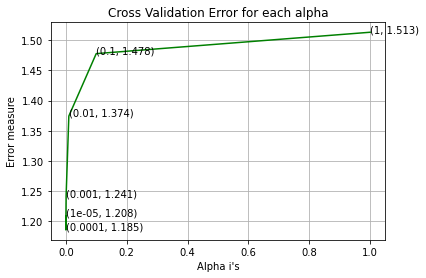

For values of best alpha =  0.0001 The train log loss is: 0.9961081757543632
For values of best alpha =  0.0001 The cross validation log loss is: 1.1853595846251803
For values of best alpha =  0.0001 The test log loss is: 1.1774526909671388


In [ ]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

 Is the Gene feature stable across all the data sets (Test, Train, Cross validation)?

 Yes, it is. Otherwise, the CV and Test errors would be significantly more than train error.

How many data points in Test and CV datasets are covered by the  220  genes in train dataset?

In [ ]:
test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Ans
1. In test data 647 out of 665 : 97.29323308270676
2. In cross validation data 516 out of  532 : 96.99248120300751


## Univariate analysis on Variation Feature

Variation is a categorical variable

How many categories are present?

In [ ]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1935
Truncating Mutations    53
Amplification           49
Deletion                41
Fusions                 23
Overexpression           4
T58I                     3
Q61R                     3
G12V                     3
I31M                     2
G12C                     2
Name: Variation, dtype: int64


In [ ]:
print("Ans: There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

Ans: There are 1935 different categories of variations in the train data, and they are distibuted as follows


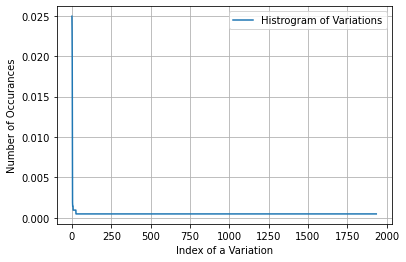

In [ ]:
s = sum(unique_variations.values);
h = unique_variations.values/s;
plt.plot(h, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()
plt.show()

[0.02495292 0.0480226  0.0673258  ... 0.99905838 0.99952919 1.        ]


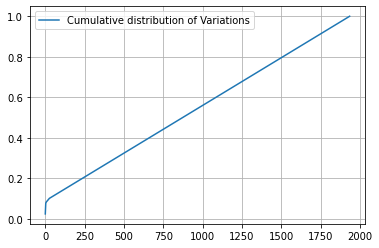

In [ ]:
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

How to featurize this Variation feature ?

We are featurizing this variation feature using 
1. One hot encoding
2. Response coding



In [ ]:
alpha =1
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", train_df))
test_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", test_df))
cv_variation_feature_responseCoding = np.array(get_gv_feature(alpha, "Variation", cv_df))


In [ ]:
print("train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature:", train_variation_feature_responseCoding.shape)

train_variation_feature_responseCoding is a converted feature using the response coding method. The shape of Variation feature: (2124, 9)


In [ ]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [ ]:
print("train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the onne-hot encoding method. The shape of Variation feature: (2124, 1964)


How good is this Variation feature in predicting y_i?

For values of alpha =  1e-05 The log loss is: 1.643206260997455
For values of alpha =  0.0001 The log loss is: 1.6369428190982402
For values of alpha =  0.001 The log loss is: 1.6476744459960082
For values of alpha =  0.01 The log loss is: 1.655451896810721
For values of alpha =  0.1 The log loss is: 1.6796237227037176
For values of alpha =  1 The log loss is: 1.683750769428197


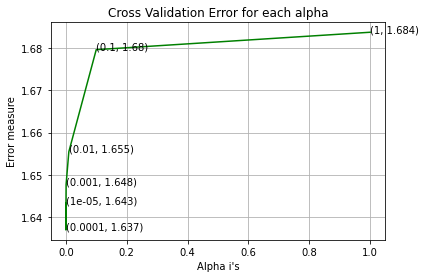

For values of best alpha =  0.0001 The train log loss is: 0.6822407567713035
For values of best alpha =  0.0001 The cross validation log loss is: 1.6369428190982402
For values of best alpha =  0.0001 The test log loss is: 1.7176555949755743


In [ ]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

In [ ]:
print("Q12. How many data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")
test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Q12. How many data points are covered by total  1935  genes in test and cross validation data sets?
Ans
1. In test data 67 out of 665 : 10.075187969924812
2. In cross validation data 58 out of  532 : 10.902255639097744


## Univariate Analysis of Text Feature

How many unique words present?

In [ ]:
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index, row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] +=1
    return dictionary
  

In [ ]:
import math

def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index, row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10 )/(total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

Building a CountVectorizer with all the words that occured minimum 3 times in train data

In [ ]:

text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# getting all the feature names (words)
train_text_features= text_vectorizer.get_feature_names()

# train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and returns (1*number of features) vector
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# zip(list(text_features),text_fea_counts) will zip a word with its number of times it occured
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))


print("Total number of unique words in train data :", len(train_text_features))

Total number of unique words in train data : 30392


In [ ]:
dict_list = []
# dict_list =[] contains 9 dictoinaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    # build a word dict based on the words in that class
    dict_list.append(extract_dictionary_paddle(cls_text))
    # append it to dict_list

# dict_list[i] is build on i'th  class text data
# total_dict is buid on whole training text data
total_dict = extract_dictionary_paddle(train_df)


confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10 )/(total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)

Response coding of text features

In [ ]:

train_text_feature_responseCoding  = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding  = get_text_responsecoding(cv_df)

In [ ]:
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding = (test_text_feature_responseCoding.T/test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding = (cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

Normalizing the features

In [ ]:
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)

In [ ]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

In [ ]:
print(Counter(sorted_text_occur))

In [ ]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Text feature seems like stable across all the datasets.

In [ ]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()

    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [ ]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% of word of test data appeared in train data")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% of word of Cross Validation appeared in train data")

# Machine Learning Models

In [ ]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])
    plot_confusion_matrix(test_y, pred_y)

In [ ]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [ ]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [ ]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))

test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(cv_df['Class']))

In [ ]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

In [ ]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding = np.hstack((test_gene_feature_responseCoding,test_variation_feature_responseCoding))
cv_gene_var_responseCoding = np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

train_x_responseCoding = np.hstack((train_gene_var_responseCoding, train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding, cv_text_feature_responseCoding))

In [ ]:
print(" Response encoding features :")
print("(number of data points * number of features) in train data = ", train_x_responseCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_responseCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_responseCoding.shape)

## Base Line Model

## Naive Bayes

Hyper parameter tuning

In [ ]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

### Testing the model with hyper parameters

In [ ]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
# to avoid rounding error while multiplying probabilites we use log-probability estimates
print("Log Loss :",log_loss(cv_y, sig_clf_probs))
print("Number of missclassified point :", np.count_nonzero((sig_clf.predict(cv_x_onehotCoding)- cv_y))/cv_y.shape[0])
plot_confusion_matrix(cv_y, sig_clf.predict(cv_x_onehotCoding.toarray()))

Feature Importance, Correctly classified point

In [ ]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices=np.argsort(-1*clf.coef_)[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

In [ ]:
test_df['TEXT'].iloc[test_point_index]

In [ ]:
no_feature

In [ ]:
test_df['Gene'].iloc[test_point_index]

In [ ]:
test_df['Variation'].iloc[test_point_index]

In [ ]:
clf.coef_.shape

In [ ]:
indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
indices[0]

In [ ]:
def get_impfeature_names(indices, text, gene, var, no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec  = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            word = gene_vec.get_feature_names()[v]
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point [{}]".format(word,yes_no))
        elif (v < fea1_len+fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point [{}]".format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point [{}]".format(word,yes_no))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

In [ ]:
for i in range(10):
  test_point_index = i
  no_feature = 100
  predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
  print("Predicted Class :", predicted_cls[0])
  print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
  print("Actual Class :", test_y[test_point_index])
  indices=np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
  print("-"*50)
  get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index].lower(),test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.1    0.0595 0.0135 0.6484 0.0282 0.0224 0.1202 0.004  0.0039]]
Actual Class : 1
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.1034 0.1682 0.0166 0.1224 0.0351 0.0397 0.5046 0.0052 0.0048]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 7
Predicted Class Probabilities: [[0.0745 0.061  0.0137 0.0819 0.0284 0.0226 0.7097 0.0042 0.004 ]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class : 3
Predicted Class Probabilities: [[0.1087 0.0875 0.3062 0.1205 0.0421 0.0328 0.2902 0.006  0.006 ]]
Actual Class : 3
--------------------------------------------------
Out of the top  100  features  0 are present in query point
Predicted Class 

Feature Importance, Incorrectly classified point

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0815 0.4835 0.0152 0.0901 0.0312 0.0251 0.2646 0.0046 0.0043]]
Actual Class : 2
--------------------------------------------------
Out of the top  100  features  0 are present in query point


## K Nearest Neighbour Classification

### Hyper parameter tuning

for alpha = 5
Log Loss : 1.7418527746746262
for alpha = 11
Log Loss : 1.5629106046953694
for alpha = 15
Log Loss : 1.4860909613097883
for alpha = 21
Log Loss : 1.3912318351001396
for alpha = 31
Log Loss : 1.2893731221137246
for alpha = 41
Log Loss : 1.212126478880733
for alpha = 51
Log Loss : 1.203811530317258
for alpha = 99
Log Loss : 1.1564036991122273


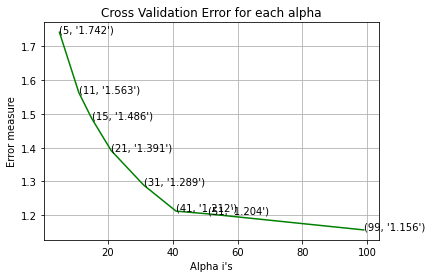

For values of best alpha =  99 The train log loss is: 0.9678081841238191
For values of best alpha =  99 The cross validation log loss is: 1.1564036991122273
For values of best alpha =  99 The test log loss is: 1.1884266922406266


In [ ]:
alpha = [5, 11, 15, 21, 31, 41, 51, 99]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Testing the model with best hyper paramaters

Log loss : 1.1564036991122273
Number of mis-classified points : 0.3966165413533835
____________________ Confusion Matrix --------------------


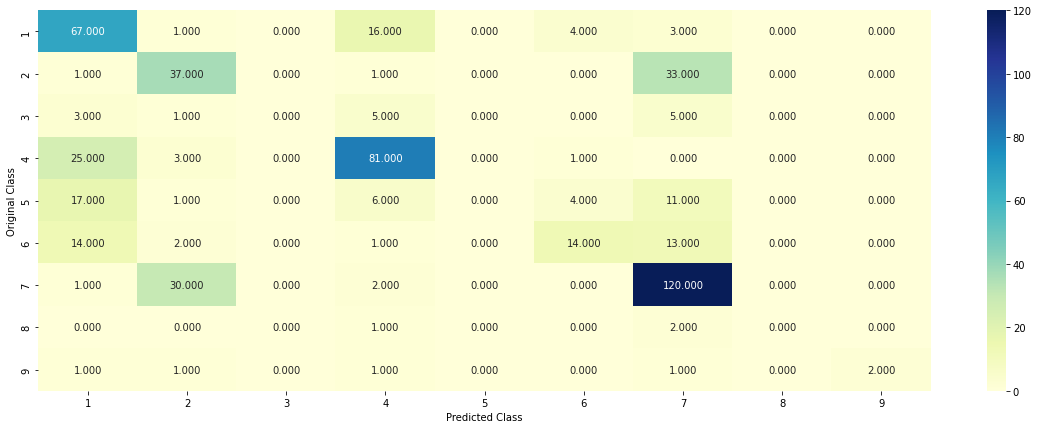

-------------------- Precision matrix (Columm Sum=1) --------------------


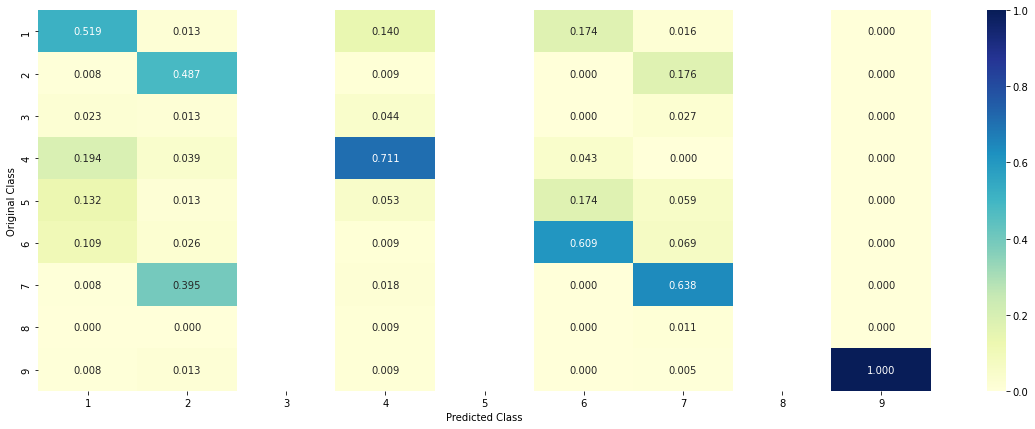

-------------------- Recall matrix (Row sum=1) --------------------


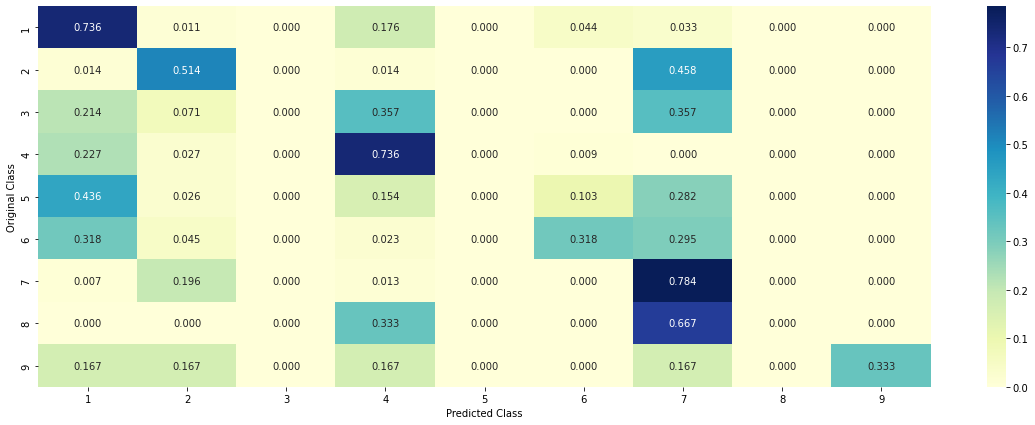

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y, cv_x_responseCoding, cv_y, clf)

Test query point -1

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 1
predicted_cls = sig_clf.predict(test_x_responseCoding[0].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("The ",alpha[best_alpha]," nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 1
Actual Class : 7
The  99  nearest neighbours of the test points belongs to classes [6 8 1 2 2 2 2 7 7 7 7 7 7 7 7 2 2 7 7 7 7 7 7 7 4 7 7 7 7 7 7 7 7 7 7 2 2
 2 7 7 2 2 7 7 1 5 7 7 7 7 2 7 7 7 7 7 7 7 7 7 7 7 7 5 6 7 7 7 7 2 2 2 2 2
 2 2 2 7 7 7 7 7 7 7 7 6 6 2 2 2 2 9 9 7 7 7 7 7 7]
Fequency of nearest points : Counter({7: 63, 2: 24, 6: 4, 1: 2, 5: 2, 9: 2, 8: 1, 4: 1})


Test query point-2

In [ ]:
clf = KNeighborsClassifier(n_neighbors=alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

test_point_index = 100

predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Actual Class :", test_y[test_point_index])
neighbors = clf.kneighbors(test_x_responseCoding[test_point_index].reshape(1, -1), alpha[best_alpha])
print("the k value for knn is",alpha[best_alpha],"and the nearest neighbours of the test points belongs to classes",train_y[neighbors[1][0]])
print("Fequency of nearest points :",Counter(train_y[neighbors[1][0]]))

Predicted Class : 7
Actual Class : 2
the k value for knn is 99 and the nearest neighbours of the test points belongs to classes [2 2 2 2 7 7 7 2 7 7 2 7 2 7 2 2 7 2 7 7 7 7 7 7 7 7 2 7 7 2 7 7 7 7 2 7 7
 7 7 7 4 4 7 7 7 5 7 7 7 7 2 2 7 7 5 7 7 7 7 2 7 2 7 7 7 7 7 2 2 7 2 2 2 2
 2 6 7 7 7 7 7 2 2 8 7 4 7 1 7 7 7 7 7 7 2 7 7 2 7]
Fequency of nearest points : Counter({7: 63, 2: 28, 4: 3, 5: 2, 6: 1, 8: 1, 1: 1})


## Logistic Regression

### With Class balancing

Hyper parameter tuning

for alpha = 1e-06
Log Loss : 1.5939406297274625
for alpha = 1e-05
Log Loss : 1.4819337420653202
for alpha = 0.0001
Log Loss : 1.18574858591601
for alpha = 0.001
Log Loss : 1.1653148979766426
for alpha = 0.01
Log Loss : 1.2817988389726547
for alpha = 0.1
Log Loss : 1.614644728429999
for alpha = 1
Log Loss : 1.7464193839790665
for alpha = 10
Log Loss : 1.7588830709095427
for alpha = 100
Log Loss : 1.760135315497508


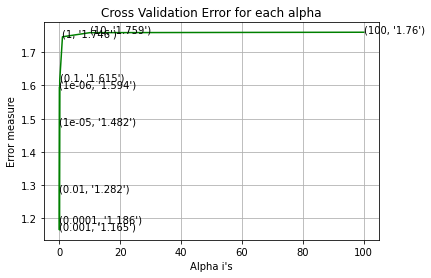

For values of best alpha =  0.001 The train log loss is: 0.7337811908944106
For values of best alpha =  0.001 The cross validation log loss is: 1.1653148979766426
For values of best alpha =  0.001 The test log loss is: 1.2020392006024336


In [ ]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    # to avoid rounding error while multiplying probabilites we use log-probability estimates
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Testing the model with best hyper paramters

Log loss : 1.1653148979766426
Number of mis-classified points : 0.37218045112781956
____________________ Confusion Matrix --------------------


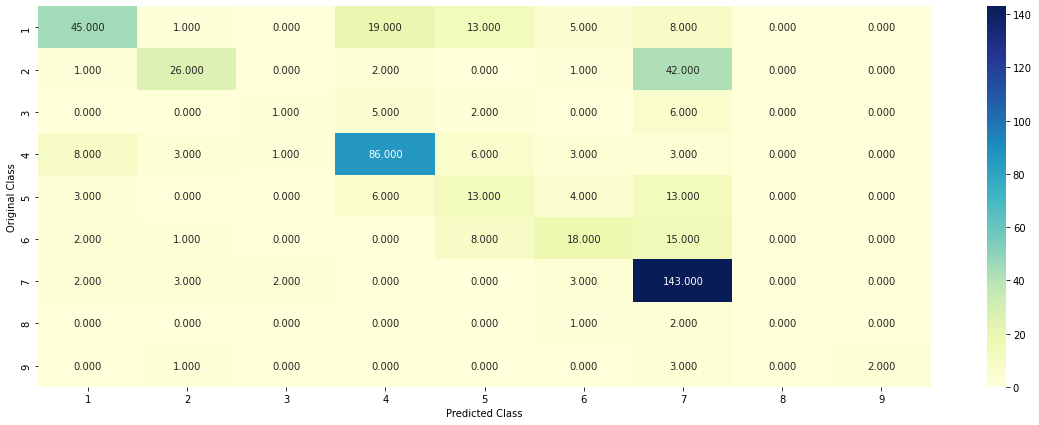

-------------------- Precision matrix (Columm Sum=1) --------------------


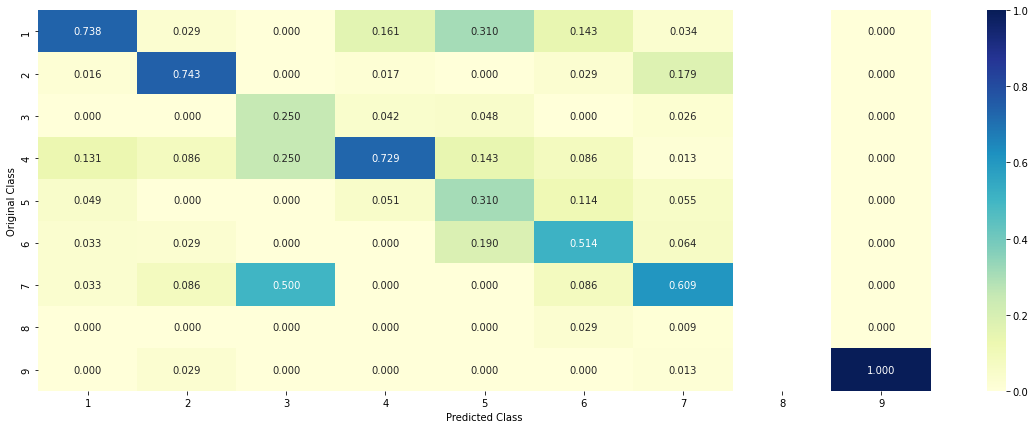

-------------------- Recall matrix (Row sum=1) --------------------


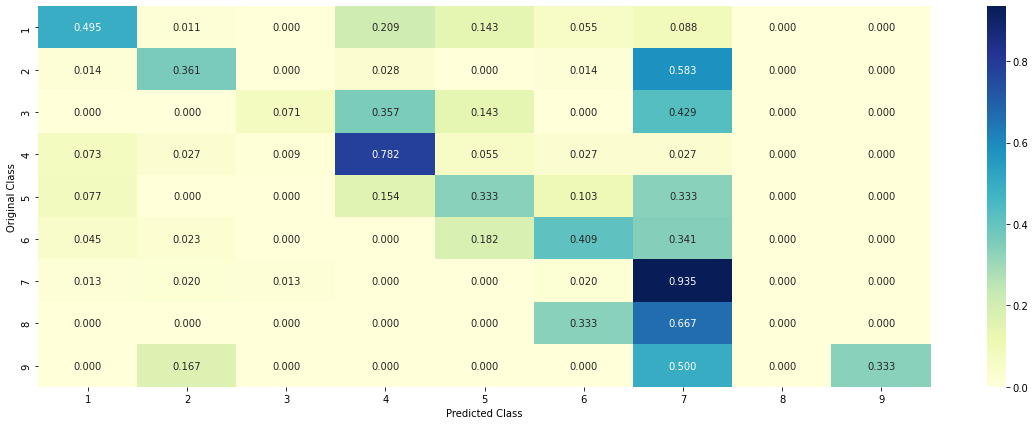

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Feature Importance

In [ ]:
def get_imp_feature_names(text, indices, removed_ind = []):
    word_present = 0
    tabulte_list = []
    incresingorder_ind = 0
    for i in indices:
        if i < train_gene_feature_onehotCoding.shape[1]:
            tabulte_list.append([incresingorder_ind, "Gene", "Yes"])
        elif i< 18:
            tabulte_list.append([incresingorder_ind,"Variation", "Yes"])
        if ((i > 17) & (i not in removed_ind)) :
            word = train_text_features[i]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
            tabulte_list.append([incresingorder_ind,train_text_features[i], yes_no])
        incresingorder_ind += 1
    print(word_present, "most importent features are present in our query point")
    print("-"*50)
    print("The features that are most importent of the ",predicted_cls[0]," class:")
    print (tabulate(tabulte_list, headers=["Index",'Feature name', 'Present or Not']))

 Correctly Classified point

In [ ]:
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0948 0.1952 0.0217 0.1268 0.0466 0.0684 0.4132 0.0236 0.0097]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


Incorrectly Classified point

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.015  0.7797 0.0058 0.0149 0.0134 0.0096 0.1559 0.0024 0.0034]]
Actual Class : 2
--------------------------------------------------
317 Text feature [favorably] present in test data point [True]
410 Text feature [discretion] present in test data point [True]
421 Text feature [kancha] present in test data point [True]
432 Text feature [t847i] present in test data point [True]
443 Text feature [l861p] present in test data point [True]
475 Text feature [g719d] present in test data point [True]
Out of the top  500  features  6 are present in query point


### Without Class balancing

Hyper parameter tuning

for alpha = 1e-06
Log Loss : 1.6076346144646871
for alpha = 1e-05
Log Loss : 1.4779735957279283
for alpha = 0.0001
Log Loss : 1.1831668310131496
for alpha = 0.001
Log Loss : 1.159465154687454
for alpha = 0.01
Log Loss : 1.2710346778801955
for alpha = 0.1
Log Loss : 1.5488402932981886
for alpha = 1
Log Loss : 1.7220626723304544


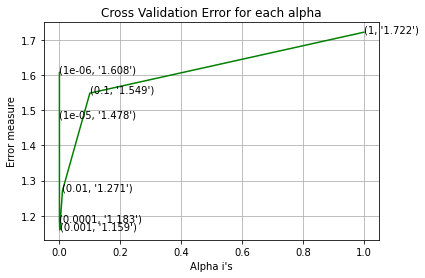

For values of best alpha =  0.001 The train log loss is: 0.7292656495979054
For values of best alpha =  0.001 The cross validation log loss is: 1.159465154687454
For values of best alpha =  0.001 The test log loss is: 1.192352355577751


In [ ]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Testing model with best hyper parameters


Log loss : 1.159465154687454
Number of mis-classified points : 0.37406015037593987
____________________ Confusion Matrix --------------------


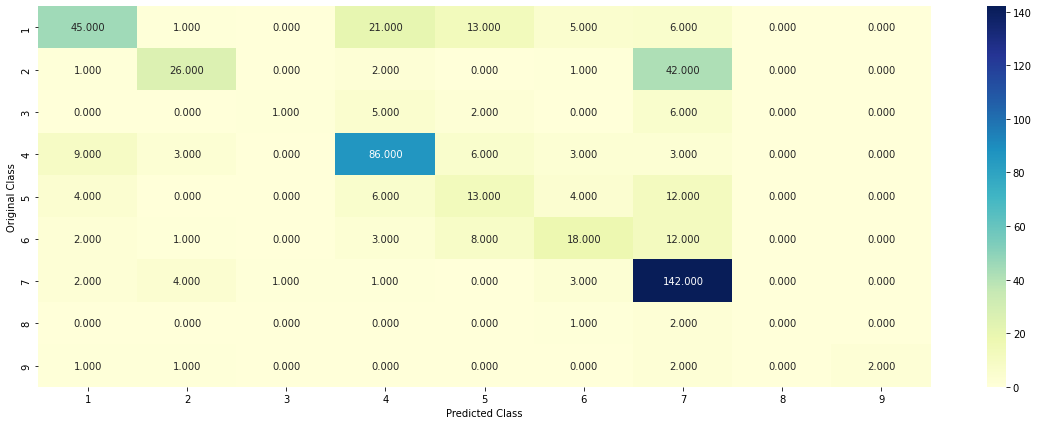

-------------------- Precision matrix (Columm Sum=1) --------------------


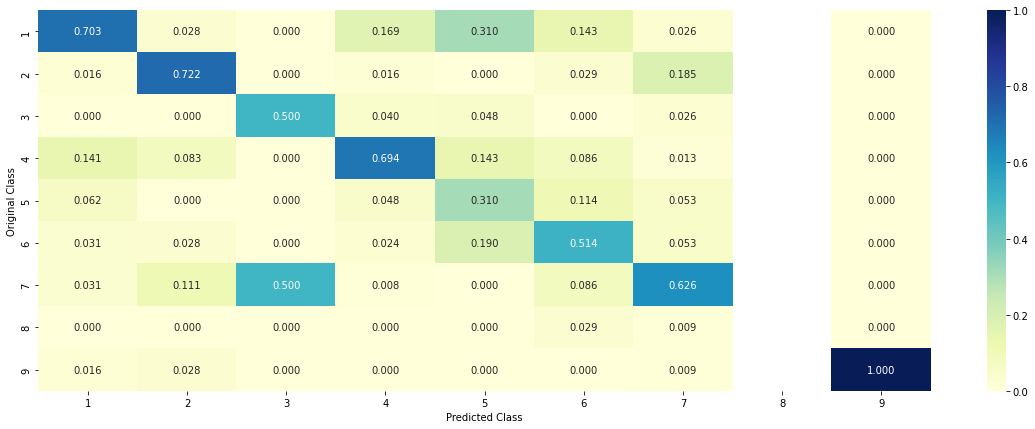

-------------------- Recall matrix (Row sum=1) --------------------


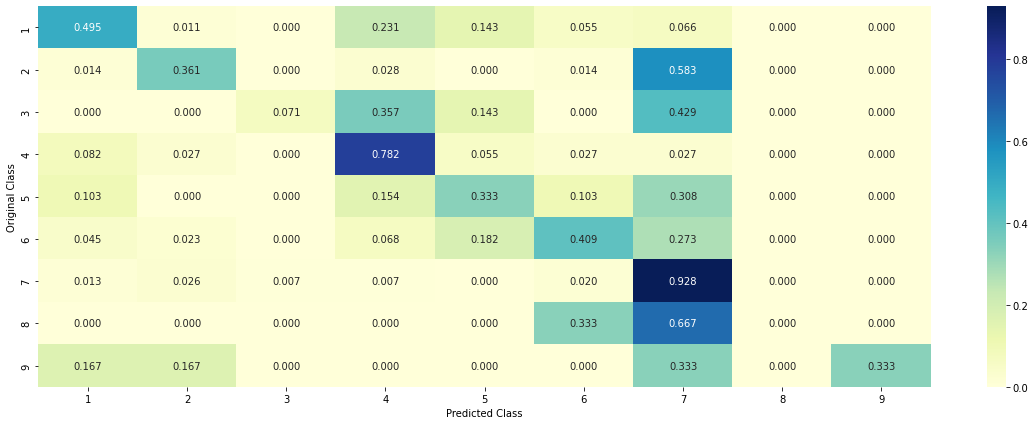

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, clf)

Feature Importance, Correctly Classified point

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0897 0.1913 0.0281 0.1144 0.0486 0.0665 0.4352 0.015  0.0111]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


Feature Importance, Inorrectly Classified point

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0159 0.8094 0.0065 0.0146 0.0146 0.0102 0.1252 0.0022 0.0012]]
Actual Class : 2
--------------------------------------------------
351 Text feature [favorably] present in test data point [True]
407 Text feature [discretion] present in test data point [True]
436 Text feature [kancha] present in test data point [True]
441 Text feature [t847i] present in test data point [True]
455 Text feature [l861p] present in test data point [True]
491 Text feature [g719d] present in test data point [True]
Out of the top  500  features  6 are present in query point


## Support Vector Machines

### Hyper paramter tuning

for C = 1e-05
Log Loss : 1.5533274607722203
for C = 0.0001
Log Loss : 1.3617531788896273
for C = 0.001
Log Loss : 1.2674131594985465
for C = 0.01
Log Loss : 1.404721722779058
for C = 0.1
Log Loss : 1.4416513854945052
for C = 1
Log Loss : 1.7553019366901756
for C = 10
Log Loss : 1.760351614663312
for C = 100
Log Loss : 1.7603516976771199


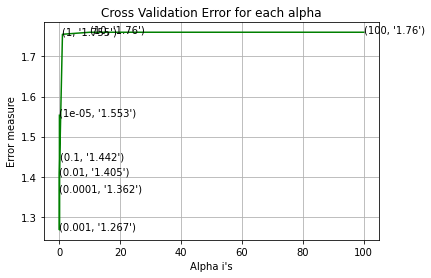

For values of best alpha =  0.001 The train log loss is: 0.7407921811044105
For values of best alpha =  0.001 The cross validation log loss is: 1.2674131594985465
For values of best alpha =  0.001 The test log loss is: 1.3165687190297126


In [ ]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
#     clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
    print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(cv_log_error_array)
# clf = SVC(C=i,kernel='linear',probability=True, class_weight='balanced')
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

Testing model with best hyper parameters

Log loss : 1.2674131594985465
Number of mis-classified points : 0.37593984962406013
____________________ Confusion Matrix --------------------


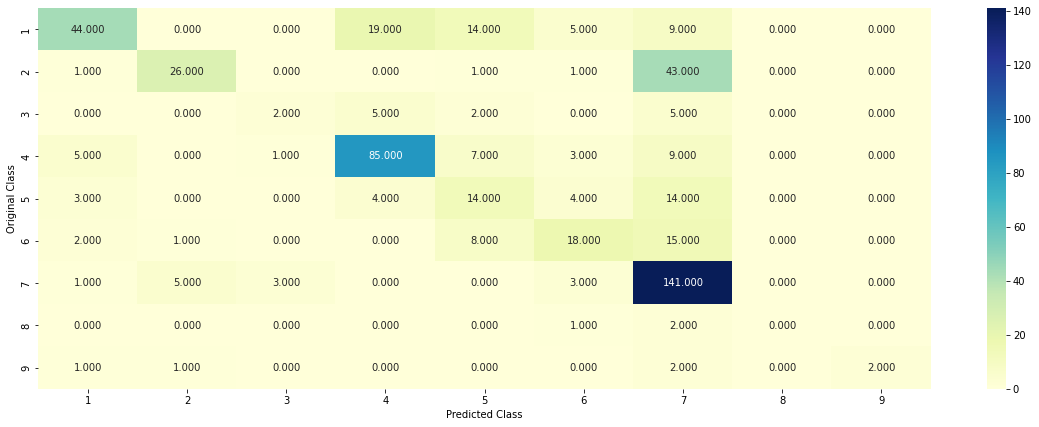

-------------------- Precision matrix (Columm Sum=1) --------------------


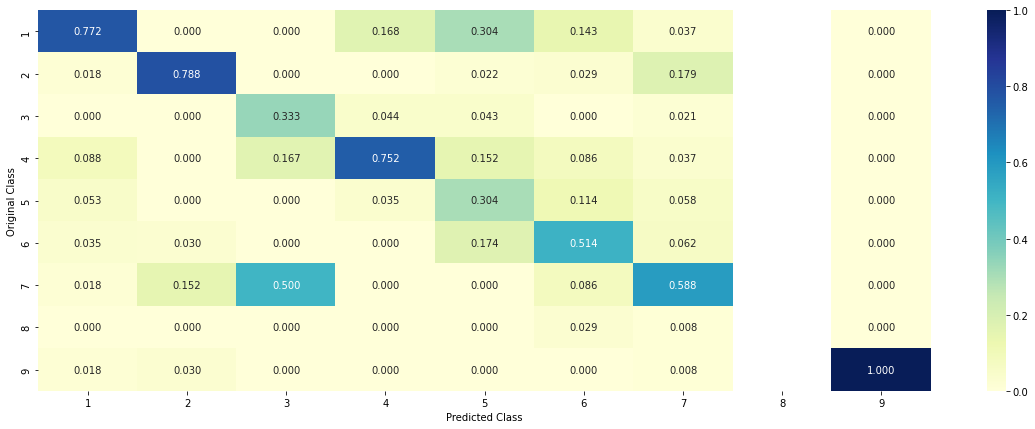

-------------------- Recall matrix (Row sum=1) --------------------


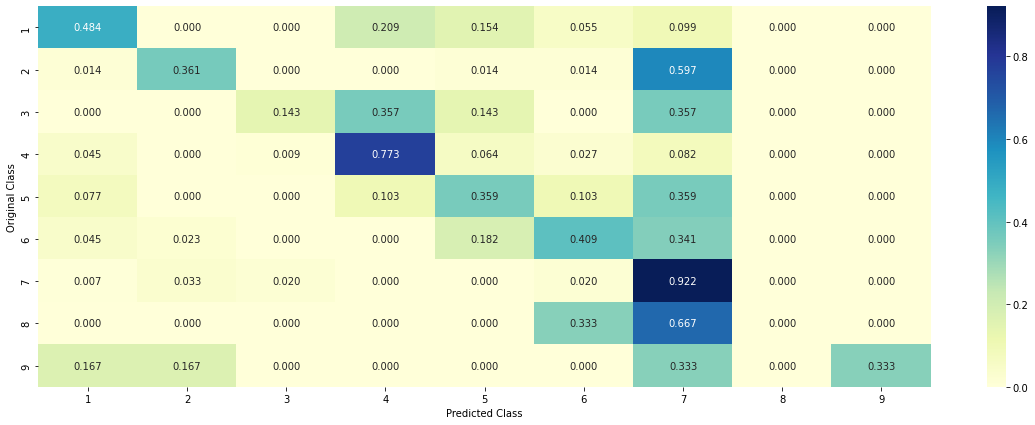

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42,class_weight='balanced')
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

Feature Importance

For Correctly classified point

In [ ]:
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(train_x_onehotCoding,train_y)
test_point_index = 1
# test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1059 0.1702 0.0347 0.1601 0.0809 0.0799 0.3461 0.0117 0.0106]]
Actual Class : 7
--------------------------------------------------
Out of the top  500  features  0 are present in query point


For incorrectly classified point

In [ ]:
test_point_index = 100
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-1*abs(clf.coef_))[predicted_cls-1][:,:no_feature]
print("-"*50)
get_impfeature_names(indices[0], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0571 0.7151 0.0141 0.0634 0.0185 0.0203 0.1044 0.0025 0.0047]]
Actual Class : 2
--------------------------------------------------
472 Text feature [discretion] present in test data point [True]
Out of the top  500  features  1 are present in query point


## Random Forest Classifier

Hyper paramter tuning (With One hot Encoding)

In [ ]:
alpha = [100,200,500,1000,2000]
max_depth = [5, 10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 100 and max depth =  5
Log Loss : 1.5517477729169395
for n_estimators = 100 and max depth =  10
Log Loss : 1.4888918537400833
for n_estimators = 200 and max depth =  5
Log Loss : 1.5476757841063078
for n_estimators = 200 and max depth =  10
Log Loss : 1.4821628145060226
for n_estimators = 500 and max depth =  5
Log Loss : 1.5491446907276147
for n_estimators = 500 and max depth =  10
Log Loss : 1.4753811694301626
for n_estimators = 1000 and max depth =  5
Log Loss : 1.5490861610455304
for n_estimators = 1000 and max depth =  10
Log Loss : 1.4755011886225848
for n_estimators = 2000 and max depth =  5
Log Loss : 1.5452443368887068
for n_estimators = 2000 and max depth =  10
Log Loss : 1.4711983345032213
For values of best estimator =  2000 The train log loss is: 1.1629078007037377
For values of best estimator =  2000 The cross validation log loss is: 1.4711983345032213
For values of best estimator =  2000 The test log loss is: 1.4383998154261626


Testing model with best hyper parameters (One Hot Encoding)

Log loss : 1.4711983345032213
Number of mis-classified points : 0.5225563909774437
____________________ Confusion Matrix --------------------


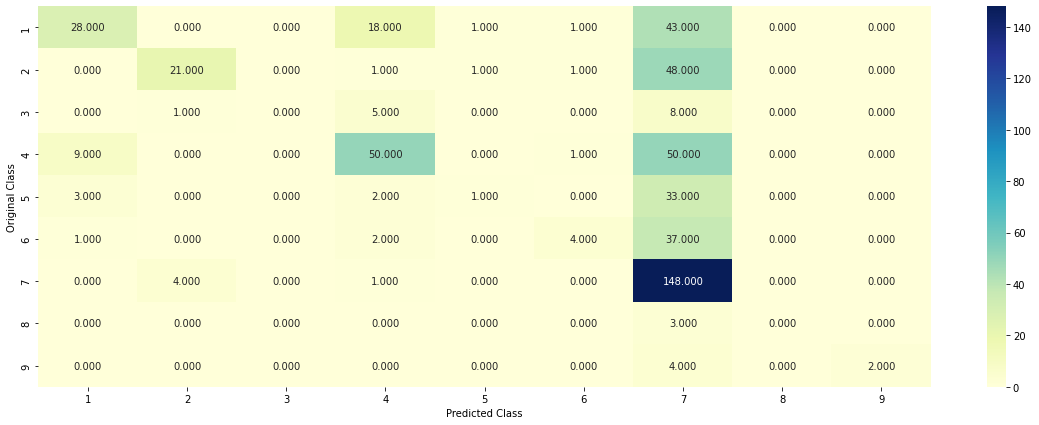

-------------------- Precision matrix (Columm Sum=1) --------------------


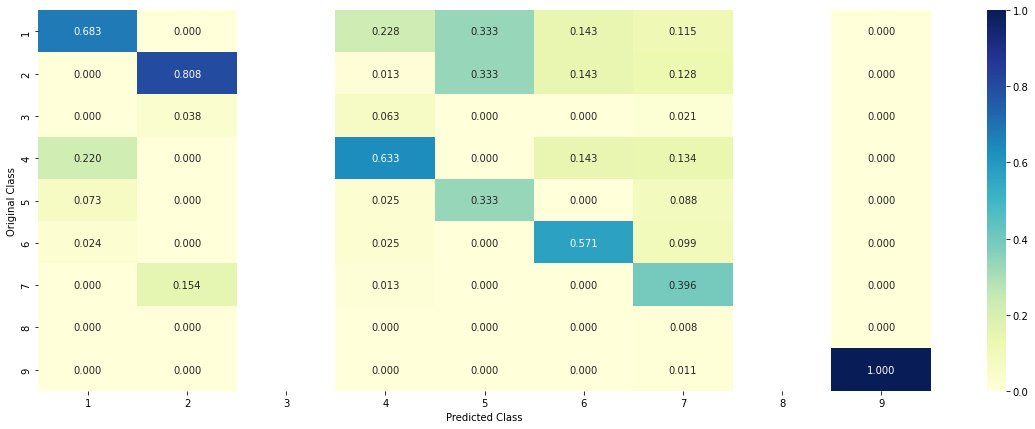

-------------------- Recall matrix (Row sum=1) --------------------


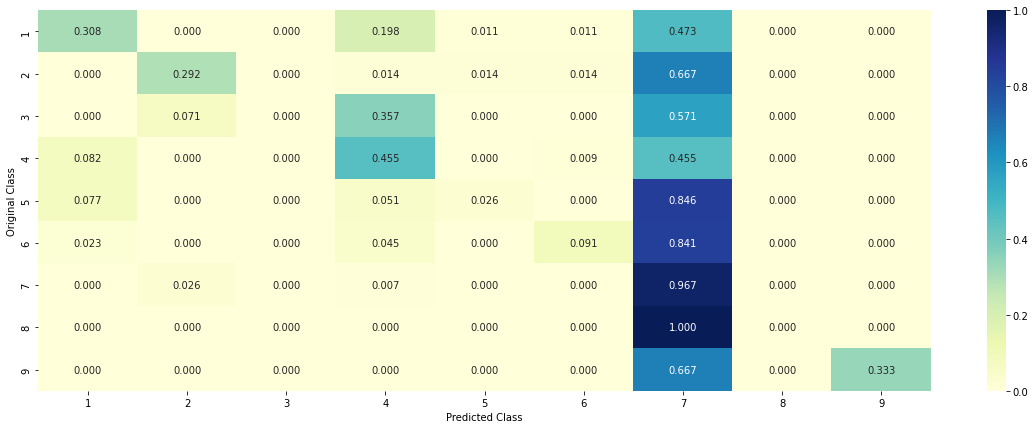

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y,cv_x_onehotCoding,cv_y, clf)

### Feature Importance

Correctly Classified point

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], random_state=42, n_jobs=-1)
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, train_y)

test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.12   0.1272 0.0289 0.1572 0.0957 0.0976 0.3598 0.0069 0.0067]]
Actual Class : 7
--------------------------------------------------
Out of the top  100  features  0 are present in query point


Incorrectly Classified point

In [ ]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actuall Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 2
Predicted Class Probabilities: [[0.0431 0.7846 0.0141 0.0363 0.0157 0.0132 0.0847 0.0038 0.0044]]
Actuall Class : 2
--------------------------------------------------
7 Text feature [kinase] present in test data point [True]
10 Text feature [mutations] present in test data point [True]
11 Text feature [tyrosine] present in test data point [True]
12 Text feature [egfr] present in test data point [True]
15 Text feature [inhibitors] present in test data point [True]
25 Text feature [receptor] present in test data point [True]
27 Text feature [treatment] present in test data point [True]
28 Text feature [tkis] present in test data point [True]
29 Text feature [factor] present in test data point [True]
38 Text feature [tki] present in test data point [True]
39 Text feature [therapy] present in test data point [True]
40 Text feature [patients] present in test data point [True]
44 Text feature [erlotinib] present in test data point [True]
46 Text feature [dna] present in t

Hyper paramter tuning (With Response Coding)

In [ ]:
alpha = [10,50,100,200,500,1000]
max_depth = [2,3,5,10]
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_responseCoding, train_y)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_responseCoding, train_y)
        sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
        cv_log_error_array.append(log_loss(cv_y, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(cv_y, sig_clf_probs)) 

best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha = ', alpha[int(best_alpha/4)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

for n_estimators = 10 and max depth =  2
Log Loss : 1.8200536351381544
for n_estimators = 10 and max depth =  3
Log Loss : 1.7579977849752315
for n_estimators = 10 and max depth =  5
Log Loss : 1.4066422348802572
for n_estimators = 10 and max depth =  10
Log Loss : 1.8188076810096252
for n_estimators = 50 and max depth =  2
Log Loss : 1.779070683198491
for n_estimators = 50 and max depth =  3
Log Loss : 1.5608868556821147
for n_estimators = 50 and max depth =  5
Log Loss : 1.4091498355024472
for n_estimators = 50 and max depth =  10
Log Loss : 1.8065617389860644
for n_estimators = 100 and max depth =  2
Log Loss : 1.7075726131243871
for n_estimators = 100 and max depth =  3
Log Loss : 1.4914615721837061
for n_estimators = 100 and max depth =  5
Log Loss : 1.3930918918815927
for n_estimators = 100 and max depth =  10
Log Loss : 1.863552740497835
for n_estimators = 200 and max depth =  2
Log Loss : 1.6650325703008066
for n_estimators = 200 and max depth =  3
Log Loss : 1.532300519217767


Log loss : 1.3930918918815927
Number of mis-classified points : 0.48120300751879697
____________________ Confusion Matrix --------------------


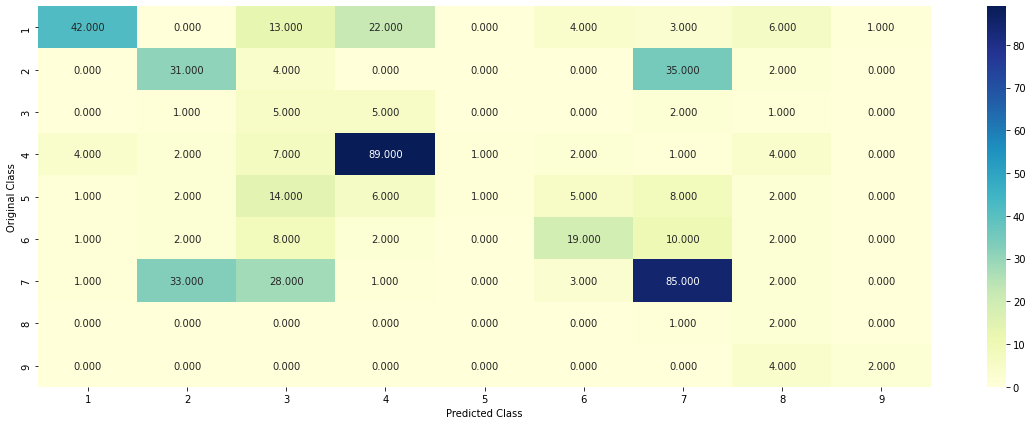

-------------------- Precision matrix (Columm Sum=1) --------------------


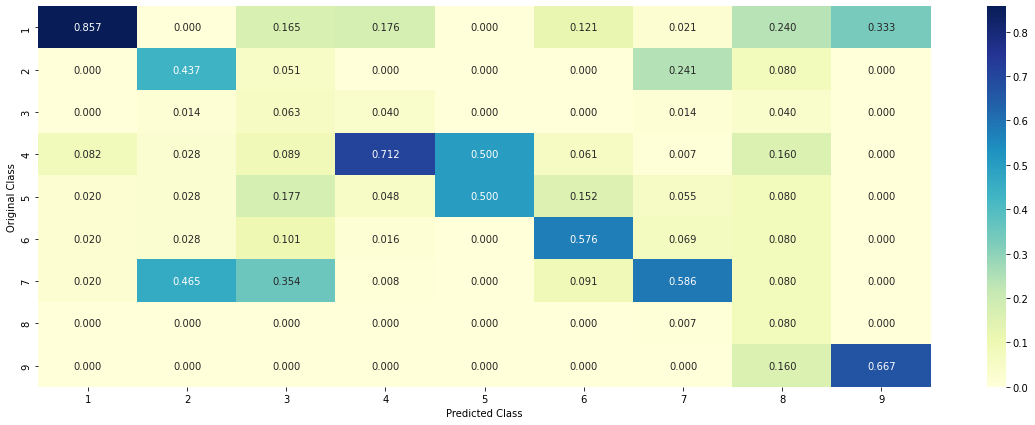

-------------------- Recall matrix (Row sum=1) --------------------


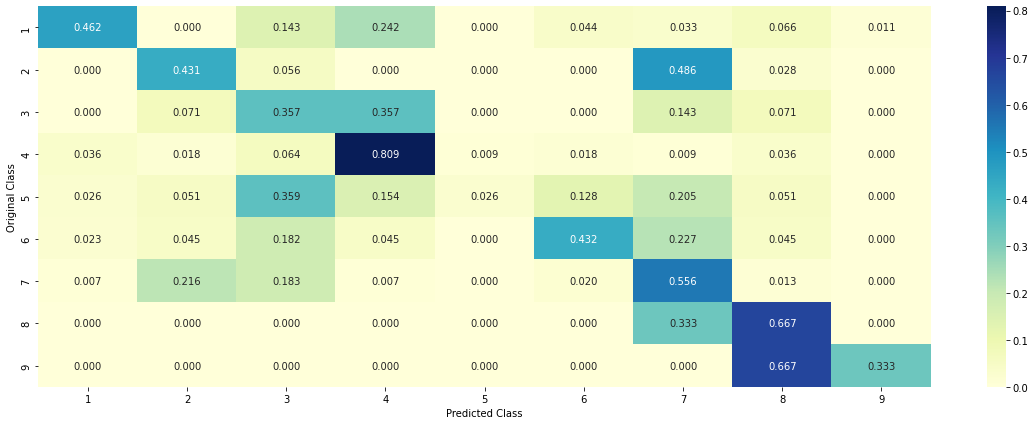

In [ ]:
clf = RandomForestClassifier(max_depth=max_depth[int(best_alpha%4)], n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_features='auto',random_state=42)
predict_and_plot_confusion_matrix(train_x_responseCoding, train_y,cv_x_responseCoding,cv_y, clf)

Feature Importance

Correctly Classified point

In [ ]:
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/4)], criterion='gini', max_depth=max_depth[int(best_alpha%4)], random_state=42, n_jobs=-1)
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_responseCoding, train_y)


test_point_index = 1
no_feature = 27
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 7
Predicted Class Probabilities: [[0.022  0.2976 0.1071 0.0313 0.0488 0.0708 0.3398 0.0518 0.0308]]
Actual Class : 7
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


Incorrectly Classified point


In [ ]:
test_point_index = 100
predicted_cls = sig_clf.predict(test_x_responseCoding[test_point_index].reshape(1,-1))
print("Predicted Class :", predicted_cls[0])
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_responseCoding[test_point_index].reshape(1,-1)),4))
print("Actual Class :", test_y[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
for i in indices:
    if i<9:
        print("Gene is important feature")
    elif i<18:
        print("Variation is important feature")
    else:
        print("Text is important feature")

Predicted Class : 2
Predicted Class Probabilities: [[0.015  0.5191 0.0987 0.0235 0.0365 0.0599 0.19   0.0364 0.0209]]
Actual Class : 2
--------------------------------------------------
Variation is important feature
Variation is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Variation is important feature
Variation is important feature
Gene is important feature
Text is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Text is important feature
Text is important feature
Variation is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Text is important feature
Variation is important feature
Text is important feature
Gene is important feature
Gene is important feature
Gene is important feature


## Stacking the models

Testing with hyper parameter tuning

In [ ]:
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, train_y)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

clf2 = SGDClassifier(alpha=1, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, train_y)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")


clf3 = MultinomialNB(alpha=0.001)
clf3.fit(train_x_onehotCoding, train_y)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, train_y)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(cv_y, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, train_y)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, train_y)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(cv_y, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
best_alpha = 999
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, train_y)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
    if best_alpha > log_error:
        best_alpha = log_error

Logistic Regression :  Log Loss: 1.17
Support vector machines : Log Loss: 1.76
Naive Bayes : Log Loss: 1.33
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.822
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.751
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.421
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.212
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.366
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.544


Testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.5306753066183133
Log loss (CV) on the stacking classifier : 1.2122273138391915
Log loss (test) on the stacking classifier : 1.265735164640523
Number of missclassified point : 0.4120300751879699
____________________ Confusion Matrix --------------------


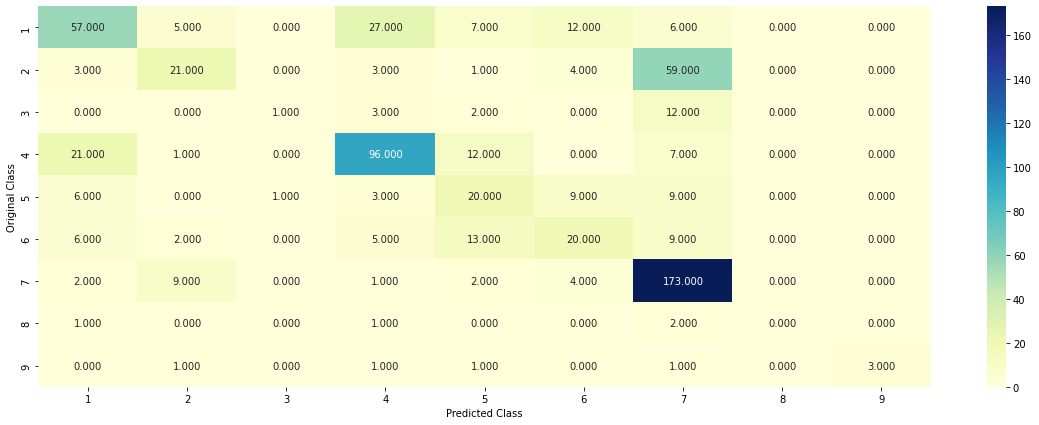

-------------------- Precision matrix (Columm Sum=1) --------------------


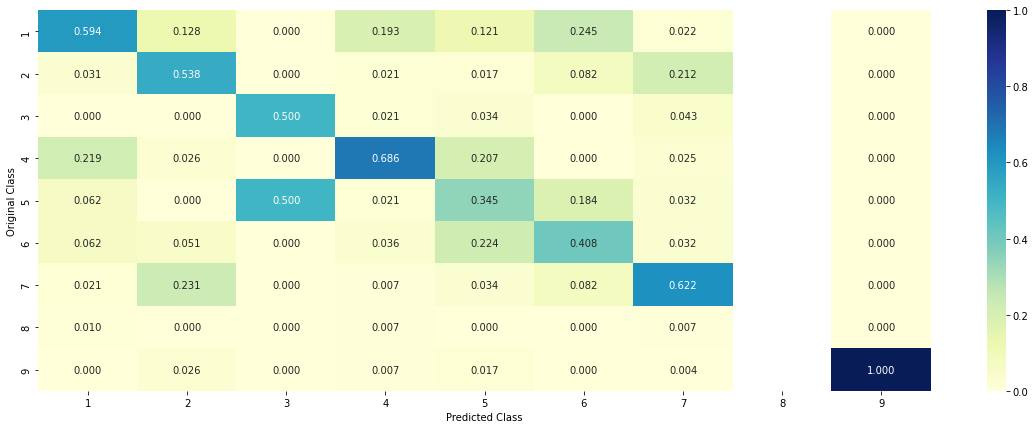

-------------------- Recall matrix (Row sum=1) --------------------


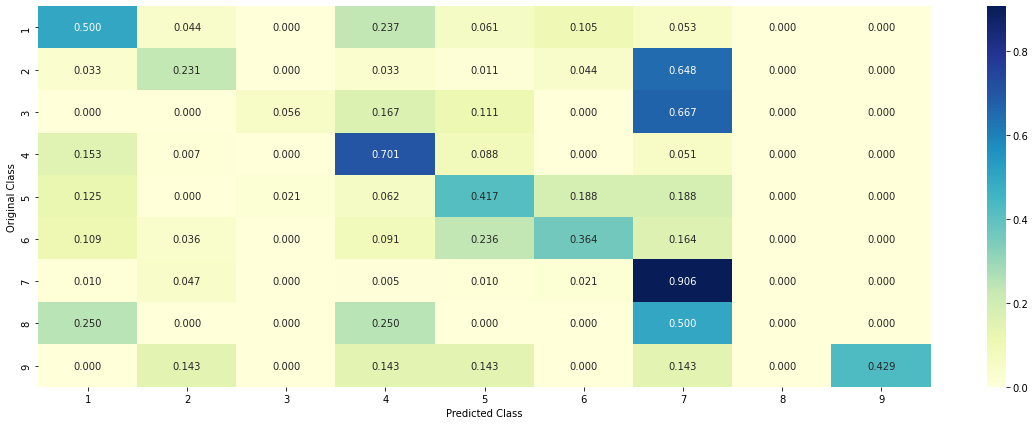

In [ ]:
lr = LogisticRegression(C=0.1)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, train_y)

log_error = log_loss(train_y, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(cv_y, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(test_y, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=sclf.predict(test_x_onehotCoding))

### Maximum Voting Classifier

Log loss (train) on the VotingClassifier : 0.9179990524875727
Log loss (CV) on the VotingClassifier : 1.3084507275323274
Log loss (test) on the VotingClassifier : 1.327333474359532
Number of missclassified point : 0.39849624060150374
____________________ Confusion Matrix --------------------


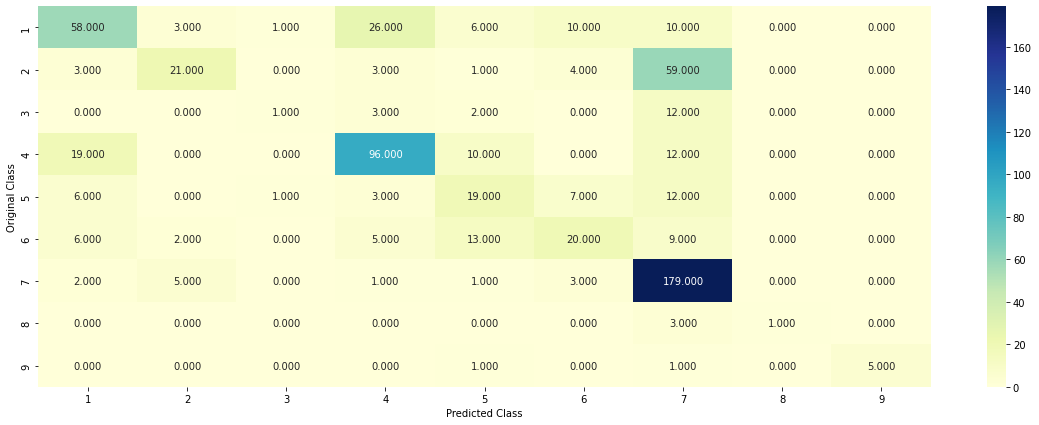

-------------------- Precision matrix (Columm Sum=1) --------------------


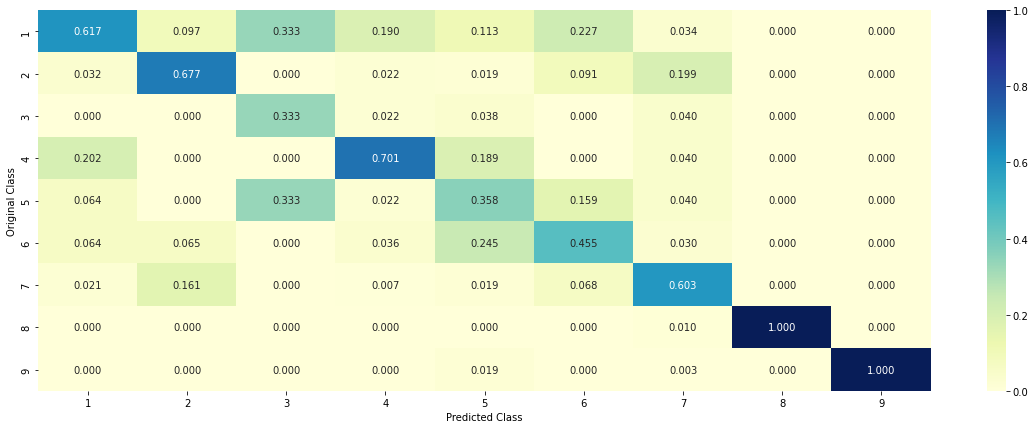

-------------------- Recall matrix (Row sum=1) --------------------


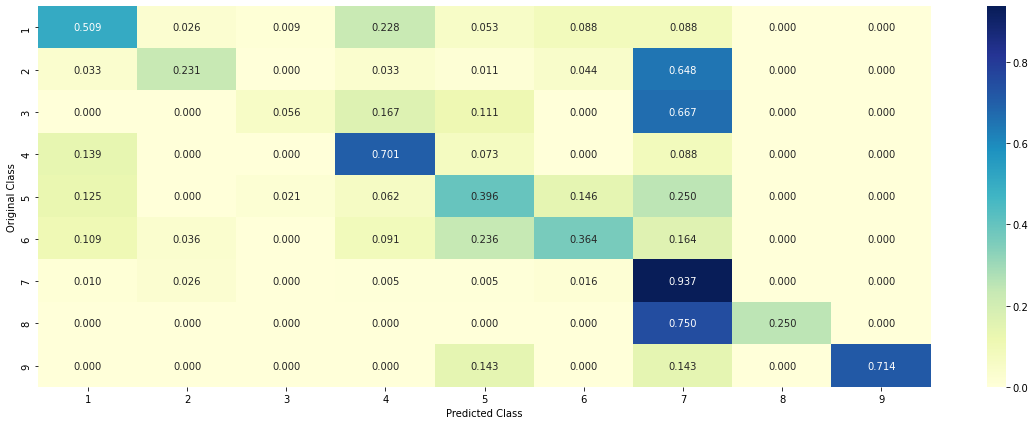

In [ ]:
from sklearn.ensemble import VotingClassifier
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('rf', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, train_y)
print("Log loss (train) on the VotingClassifier :", log_loss(train_y, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(cv_y, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(test_y, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- test_y))/test_y.shape[0])
plot_confusion_matrix(test_y=test_y, predict_y=vclf.predict(test_x_onehotCoding))